In [3]:
import lightkurve as lk
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import plotly.express as px
import plotly.graph_objects as go


C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(




## 🧩 `build_segmented_dataset()` — Function Summary

The `build_segmented_dataset()` function takes a **light curve** (from the [Lightkurve](https://docs.lightkurve.org/) library) and converts it into a **segmented, event-labeled dataset** suitable for machine learning.

### **Purpose**

To break a continuous light curve into smaller overlapping segments, compute statistical features for each segment, and label segments containing significant flux dips as potential transit events.

### **How it works**

1. **Input:** a `lightkurve.LightCurve` object
2. **Segmentation:** divides the flux time series into equal-length windows (`segment_length`)
3. **Feature extraction:** computes basic statistical features per segment:

   * mean, std, min, max flux
   * skewness, kurtosis
   * transit depth (median − min)
4. **Event detection:** flags segments that contain points below
   `median_flux - sigma * std_flux`
   as **events** (`label = 1`), otherwise **non-events** (`label = 0`)
5. **Output:** returns a `pandas.DataFrame` where each row represents one segment.

### **Output structure**

| segment_start | segment_end | mean_flux | std_flux | min_flux | max_flux | skew | kurtosis | transit_depth | label |
| ------------- | ----------- | --------- | -------- | -------- | -------- | ---- | -------- | ------------- | ----- |

---



In [15]:
def build_segmented_dataset_datetime(
    lc,
    segment_length=200,
    overlap=0,
    sigma=3,
    time_origin=pd.Timestamp("2000-01-01")
):
    """
    Build segmented dataset from lightcurve `lc` for ML and grouped CV.

    Returns DataFrame with:
        DateTime  (segment midpoint)
        Label     (1 if event in segment else 0)
        feature columns...
    """
    flux = lc.flux.value
    time = lc.time.value
    n = len(flux)
    step = segment_length - overlap

    median_flux = np.median(flux)
    std_flux = np.std(flux)

    # simple threshold-based event detection
    event_mask = flux < median_flux - sigma * std_flux
    event_indices = np.where(event_mask)[0]

    segments = []

    for start in range(0, n - segment_length + 1, step):
        end = start + segment_length
        seg_flux = flux[start:end]
        seg_time = time[start:end]

        # --- compute features ---
        mean_flux = np.mean(seg_flux)
        std_flux = np.std(seg_flux)
        min_flux = np.min(seg_flux)
        max_flux = np.max(seg_flux)
        skewness = skew(seg_flux)
        kurt = kurtosis(seg_flux)
        depth = np.median(seg_flux) - np.min(seg_flux)

        # --- label: event within segment? ---
        has_event = int(np.any((event_indices >= start) & (event_indices < end)))

        # --- datetime midpoint for grouped CV ---
        midpoint = seg_time[len(seg_time)//2]
        dt_mid = time_origin + pd.to_timedelta(midpoint, unit="D")

        segments.append({
            "DateTime": dt_mid,
            "segment_start": seg_time[0],
            "segment_end": seg_time[-1],
            "mean_flux": mean_flux,
            "std_flux": std_flux,
            "min_flux": min_flux,
            "max_flux": max_flux,
            "skew": skewness,
            "kurtosis": kurt,
            "transit_depth": depth,
            "Label": has_event
        })

    df = pd.DataFrame(segments)

    # ensure datetime and label have correct types
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["Label"] = df["Label"].astype(int)

    return df

In [16]:
all_segments = []

for target in ["Kepler-10"]:
    search = lk.search_lightcurve(target, mission="Kepler", quarter=10)
    lc = search.download().remove_nans().normalize().flatten(window_length=401)
    
    df = build_segmented_dataset_datetime(lc, segment_length=200, sigma=5)
    df["target_id"] = target
    all_segments.append(df)

# Merge all targets into one DataFrame
df_all = pd.concat(all_segments, ignore_index=True)
df_all.to_csv("transit_segments_all.csv", index=False)

print("✅ Saved combined dataset for all targets.")

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


✅ Saved combined dataset for all targets.


In [4]:

df = pd.read_csv("transit_segments_all.csv")


target = "Kepler-10"
df_target = df[df["target_id"] == target]


fig = go.Figure()


fig.add_trace(go.Scatter(
    x=df_target.index,
    y=df_target["mean_flux"],
    mode='lines+markers',
    name='Mean Flux',
    line=dict(color='blue'),
    marker=dict(size=6)
))


transit_segments = df_target[df_target["Label"] == 1]
fig.add_trace(go.Scatter(
    x=transit_segments.index,
    y=transit_segments["mean_flux"],
    mode='markers',
    name='Transit',
    marker=dict(color='red', size=8, symbol='circle-open')
))

fig.update_layout(
    title=f"Segmented Lightcurve for {target}",
    xaxis_title="Segment Index",
    yaxis_title="Normalized Flux",
    template="plotly_white"
)

fig.show()

In [16]:


from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipelines = [
    Pipeline([
        ('scaler', StandardScaler()),
         ('selector', SelectKBest()),
        ('model', RandomForestClassifier(n_estimators=50, random_state=42))
    ])
]

param_grids = [
    {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 5]
    }
]


In [19]:
import sys
import os

# Lägg till mappen en nivå upp i Pythons sökväg
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import grouped_timeserie_cv

print(grouped_timeserie_cv.__file__)

df["flux_range"] = df["max_flux"] - df["min_flux"]
df["std_over_mean"] = df["std_flux"] / df["mean_flux"]
df['DateTime'] = pd.to_datetime(df['DateTime'])

columns_to_keep = ["DateTime", "flux_range", "std_over_mean", "Label"]

df_selected = df[columns_to_keep].copy()
grouped_cv =  grouped_timeserie_cv.GroupedTimeSerieCV()
result = grouped_cv.classify(df_selected, pipelines, param_grids, 'h', 'DateTime', 'Label', 'accuracy')

c:\Projects\ExoplanetHunter\ExoplanetHunter-TransitML\grouped_timeserie_cv\__init__.py
Beginning classification with grouped time series cross-validation...


C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.



Process model: RandomForestClassifier
Score: 0.9634703196347032


C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is gre

Best model: RandomForestClassifier
Best parameters for best results: {'model__max_depth': None, 'model__n_estimators': 50}
Selected features: ['flux_range', 'std_over_mean']


C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.

C:\Users\goran.backlund\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning:

k=10 is greater than n_features=2. All the features will be returned.



<Figure size 800x600 with 0 Axes>

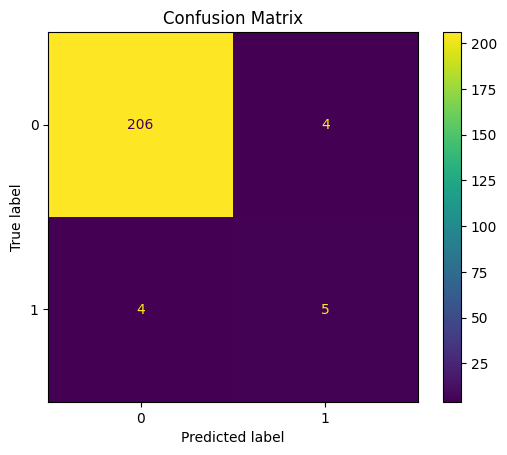

In [20]:
# Plot confusion matrix
grouped_cv.plotter.plot_confusion_matrix(result.confusion_matrices, result.class_labels)

# Plot learning curve
grouped_cv.plotter.plot_learning_curve(result.train_sizes, result.train_mean, result.train_std, result.test_mean, result.test_std)
